In [26]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
import tqdm


In [27]:
df = pd.read_csv('./total.csv')
df.tail()

,Date,S&P,currency,gold,kospi
5320,2024-04-22,5010.600098,1373.930054,2332.199951,2629.439941
5321,2024-04-23,5070.549805,1378.839966,2327.699951,2623.020020
5322,2024-04-24,5071.629883,1370.479980,2324.500000,2675.750000
5323,2024-04-25,5048.419922,1376.969971,2345.600098,2628.620117
5324,2024-04-26,5048.419922,1376.969971,2345.600098,2654.820068


In [28]:
col_names = df.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi']


In [29]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.973
LR = 1e-4

In [30]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :].drop('Date', axis=1)
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :].drop('Date', axis=1)
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi
mean,2.107460e+03,1124.367166,1226.672090,1921.365886
var,1.127514e+06,11700.397580,203706.852049,287896.130792
max,4.796560e+03,1571.400024,2051.500000,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027


In [31]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi
5320,1.051951,0.711605,1.167412,0.738643
5321,1.066502,0.718775,1.164728,0.736160
5322,1.066764,0.706566,1.162820,0.756554
5323,1.061131,0.716044,1.175404,0.738326
5324,1.061131,0.716044,1.175404,0.748459


In [32]:
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [33]:
iw = 128
ow = 1
# ow = 10

train_dataset = windowDataset(train_data['kospi'], input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = windowDataset(test_data['kospi'], input_window=iw, output_window=ow, stride=1)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [34]:
train_dataset.__len__()

5053

In [35]:
test_dataset.__len__()

16

In [36]:
next(iter(train_loader))

[tensor([[[0.1576],
          [0.1522],
          [0.1499],
          ...,
          [0.3325],
          [0.3271],
          [0.3268]],
 
         [[0.4313],
          [0.4423],
          [0.4394],
          ...,
          [0.4858],
          [0.4888],
          [0.4940]],
 
         [[0.4929],
          [0.4967],
          [0.4968],
          ...,
          [0.4775],
          [0.4841],
          [0.4858]],
 
         ...,
 
         [[0.4836],
          [0.4900],
          [0.4900],
          ...,
          [0.5368],
          [0.5381],
          [0.5396]],
 
         [[0.2262],
          [0.2204],
          [0.2288],
          ...,
          [0.2521],
          [0.2489],
          [0.2518]],
 
         [[0.8870],
          [0.8989],
          [0.9141],
          ...,
          [0.9168],
          [0.9354],
          [0.9387]]], dtype=torch.float64),
 tensor([[[0.3372]],
 
         [[0.4958]],
 
         [[0.4854]],
 
         [[0.7304]],
 
         [[0.7724]],
 
         [[0.4949]],

In [37]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [38]:
device = torch.device("cuda")
lr = 1e-4
nlayers = 12
nhead = 8
model = TFModel(iw, ow, 512, nhead, nlayers, 0.1).to(device) # iw, ow, d_model, nhead, nlayers, dropout
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

c:\Users\alan.kwak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [39]:
train_result = pd.DataFrame(columns=['epoch', 'loss'])

In [40]:
epoch = 200
model.train()
progress = tqdm.tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))
    train_result.loc[i] = [i, batchloss.cpu().item() / len(train_loader)]

loss: 0.000132: 100%|██████████| 200/200 [2:16:50<00:00, 41.05s/it]  


In [41]:
save_path = 'kospi_out' + str(ow) + '_lyaers' + str(nlayers) + '_nhead' + str(nhead) + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
train_result

,epoch,loss
0,0.0,0.053054
1,1.0,0.040121
2,2.0,0.040373
3,3.0,0.016409
4,4.0,0.007906
...,...,...
195,195.0,0.000145
196,196.0,0.000142
197,197.0,0.000172
198,198.0,0.000138


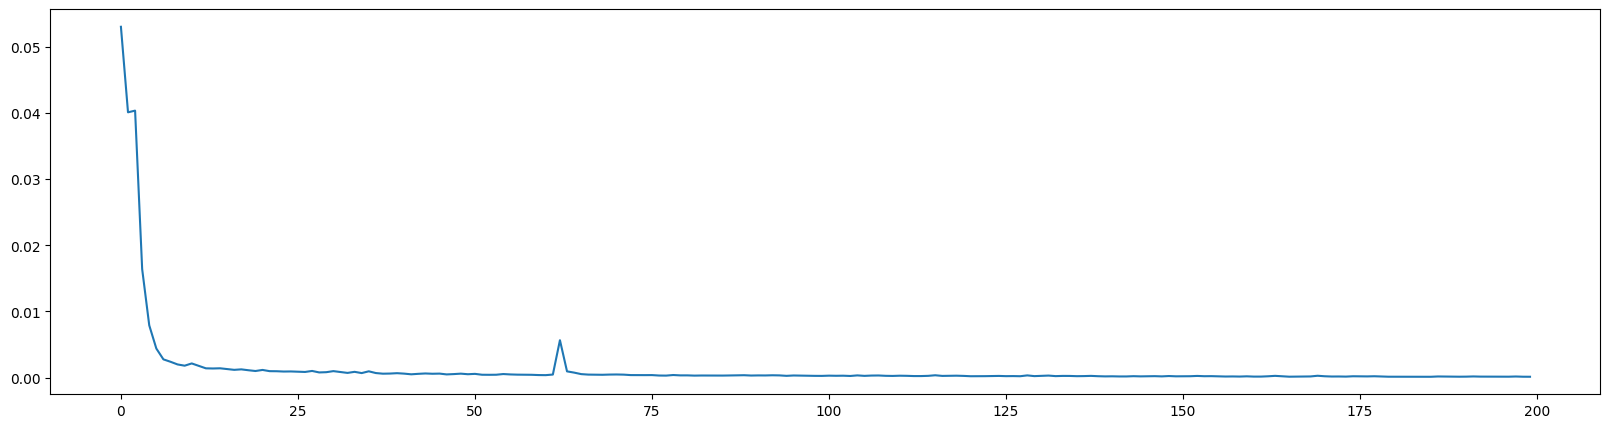

In [42]:
plt.figure(figsize=(20,5))
plt.plot(train_result['loss'].values)
plt.show()

In [43]:
def evaluate(data):
    input = torch.tensor(data).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

In [44]:
train_data['kospi'][-128:]

5053    0.712429
5054    0.716231
5055    0.717940
5056    0.716076
5057    0.717619
          ...   
5176    0.675072
5177    0.652107
5178    0.651298
5179    0.653282
5180    0.653282
Name: kospi, Length: 128, dtype: float64

In [45]:
x_data, y_data = test_dataset.__getitem__(-1)
y_data

array([[0.74845882]])

In [46]:
test_data['kospi'].iloc[-20:]

5305    0.784442
5306    0.786492
5307    0.768628
5308    0.782176
5309    0.771428
5310    0.772759
5311    0.767928
5312    0.767928
5313    0.768624
5314    0.758901
5315    0.754496
5316    0.730981
5317    0.721138
5318    0.740677
5319    0.724109
5320    0.738643
5321    0.736160
5322    0.756554
5323    0.738326
5324    0.748459
Name: kospi, dtype: float64

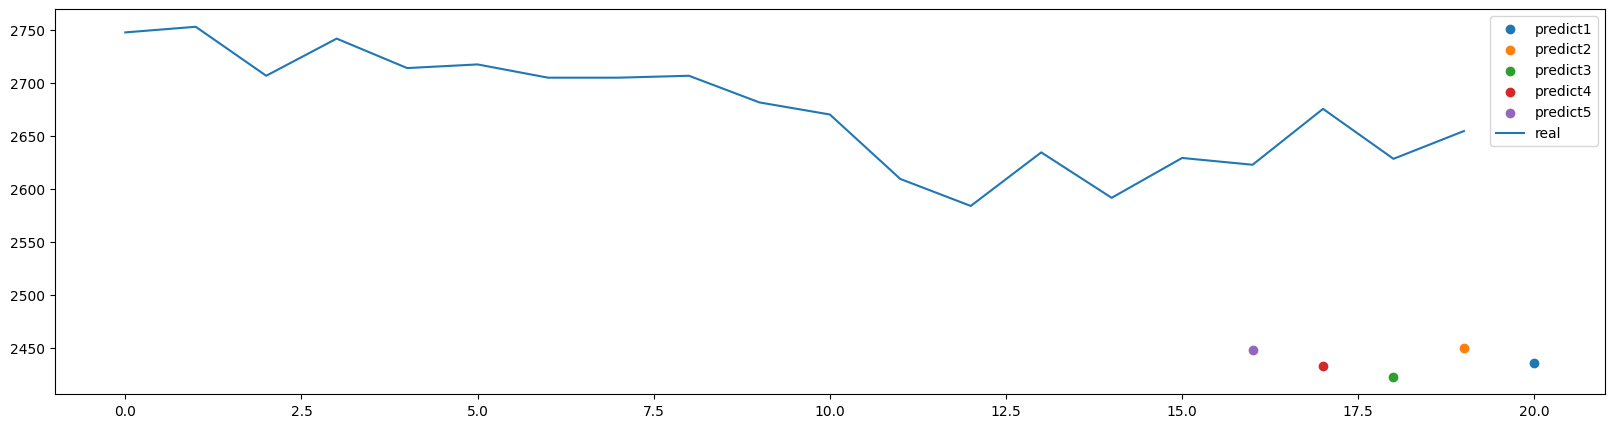

In [47]:
df_result = pd.DataFrame()
plt.figure(figsize=(20,5))
iters = 5
for i in range(iters):
    x_data, y_data = test_dataset.__getitem__(-(i+1))
    result = evaluate(x_data)
    x = result[0]
    min = scale_params.loc['min', 'kospi']
    max = scale_params.loc['max', 'kospi']
    x =  x * (max - min) + min
    # plt.plot(range(10-i,20-i), x, label="predict" +str(i+1))
    plt.scatter(20-i, x, label="predict" +str(i+1))
    df_result[str(i)] = x

real = df['kospi'].values

plt.plot(range(20),real[-20:], label="real")
# plt.plot(range(10,20),x, label="predict")
plt.legend()
plt.show()

In [48]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# for i in range(iters):
#     print(MAPEval(df_result[str(i)].values, real[-10-i-1:-i-1]))
y_pred = [df_result.iloc[0, i] for i in range(1, iters)]


print(MAPEval(y_pred, real[-iters+1:]))
# df_result.tail()


7.804364322772585


In [49]:
real[-iters:]

array([2629.43994141, 2623.02001953, 2675.75      , 2628.62011719,
       2654.82006836])

In [50]:
df_result

,0,1,2,3,4
0,2435.882324,2450.385986,2423.062012,2433.44165,2448.61499
